# Import function of interests

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import Image, display
import itertools # Pour créer des iterateurs
import random

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks

%matplotlib inline

# **Functions for Grad CAM**

In [2]:
def softmax(vector):
    e = np.exp(vector)
    vector_proba = e / e.sum()
    final = round(max(vector_proba)*100, 2)
    return vector_proba, final

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, inner_model, last_conv_layer_name, pred_index=None):
    if inner_model == None:
        inner_model = model
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(inputs=[inner_model.inputs],
                      outputs=[inner_model.get_layer(last_conv_layer_name).output,
                               inner_model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        (last_conv_layer_output, preds) = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
#    pooled_grads = tf.reduce_mean(grads, axis=-1)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, beta=1):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img2 = img
    #display(img2) ## uncomment if you want the funtion to directly display the image
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    jet_heatmap2 = keras.preprocessing.image.array_to_img(jet_heatmap)
    #display(jet_heatmap2) ## uncomment if you want the funtion to directly display the image

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img * beta
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    
    
    #display(superimposed_img) ## uncomment if you want the funtion to directly display the image
    return img2, jet_heatmap2, superimposed_img

# **Set the paths and load models + csv and data to test**

In [3]:
## Load the different models

model_fam_path = "/Users/Adrien/Google Drive/Colab Notebooks/test_save/model_effnetB1_final_20210624.h5"
model_label0_path = "/Users/Adrien/Google Drive/Colab Notebooks/modeles_genus/model_label0_effnetB1_fin_20210627.h5"
model_label1_path = "/Users/Adrien/Google Drive/Colab Notebooks/modeles_genus/model_label1_effnetB1_fin_20210627.h5"
model_label2_path = "/Users/Adrien/Google Drive/Colab Notebooks/modeles_genus/model_label2_effnetB1_fin_20210627.h5"
model_label3_path = "/Users/Adrien/Google Drive/Colab Notebooks/modeles_genus/model_label3_effnetB1_fin_20210627.h5"
model_label4_path = "/Users/Adrien/Google Drive/Colab Notebooks/modeles_genus/model_label4_effnetB1_fin_20210627.h5"

print("load Models...")
print("Model famille...")
model_fam = load_model(model_fam_path)
print("Model 0...")
model_label0 = load_model(model_label0_path)
print("Model 1...")
model_label1 = load_model(model_label1_path)
print("Model 2...")
model_label2 = load_model(model_label2_path)
print("Model 3...")
model_label3 = load_model(model_label3_path)
print("Model 4...")
model_label4 = load_model(model_label4_path)


## Indicate the family names and genus names

family_names = ['Inocybaceae','Omphalotaceae','Fomitopsidaceae','Physalacriaceae','Marasmiaceae']

genus_names_label0 = ['Inocybe', 'Crepidotus', 'Simocybe', 'Flammulaster']
genus_names_label1 = ['Gymnopus', 'Omphalotus', 'Rhodocollybia', 'Marasmiellus']
genus_names_label2 = ['Fomitopsis', 'Laetiporus', 'Phaeolus', 'Postia', 'Ischnoderma', 'Piptoporus', 'Daedalea', 'Antrodia']
genus_names_label3 = ['Armillaria', 'Hymenopellis', 'Flammulina', 'Strobilurus', 'Oudemansiella', 'Cyptotrama']
genus_names_label4 = ['Marasmius', 'Megacollybia', 'Gerronema', 'Tetrapyrgos', 'Atheniella', 'Clitocybula']

## Load and concatenate the csv(s) with genus label

csv_label0 = "/Users/Adrien/DataScientist/projet_Mushroom/dataset_label0_Inocybaceae.csv"
csv_label1 = "/Users/Adrien/DataScientist/projet_Mushroom/dataset_label1_Omphalotaceae.csv"
csv_label2 = "/Users/Adrien/DataScientist/projet_Mushroom/dataset_label2_Fomitopsidaceae.csv"
csv_label3 = "/Users/Adrien/DataScientist/projet_Mushroom/dataset_label3_Physalacriaceae.csv"
csv_label4 = "/Users/Adrien/DataScientist/projet_Mushroom/dataset_label4_Marasmiaceae.csv"

df_test0 = pd.read_csv(csv_label0)
df_test1 = pd.read_csv(csv_label1)
df_test2 = pd.read_csv(csv_label2)
df_test3 = pd.read_csv(csv_label3)
df_test4 = pd.read_csv(csv_label4)

df_int = pd.concat([df_test0, df_test1, df_test2, df_test3, df_test4])

data_train, data_test = train_test_split(df_int, test_size=0.2, random_state=42)

#X_test = []
#for filepath in tqdm(data_test['filepath']):
#    # Lecture du fichier
#    im = tf.io.read_file(filepath)
#    # On décode le fichier
#    im = tf.image.decode_jpeg(im, channels=3)
#    # Redimensionnement
#    im = tf.image.resize(im, size=(256, 256))
#    X_test.append([im])
#X_test = tf.concat(X_test, axis=0)
## prepare the labels !
#y_test_fam = data_test["label_family"].astype(int)

load Models...
Model famille...
Model 0...
Model 1...
Model 2...
Model 3...
Model 4...


# Predict and provide Grad-Cam interpretation

Attention, bien penser à indiquer un numéro d'image que l'on souhaite analyser !!!

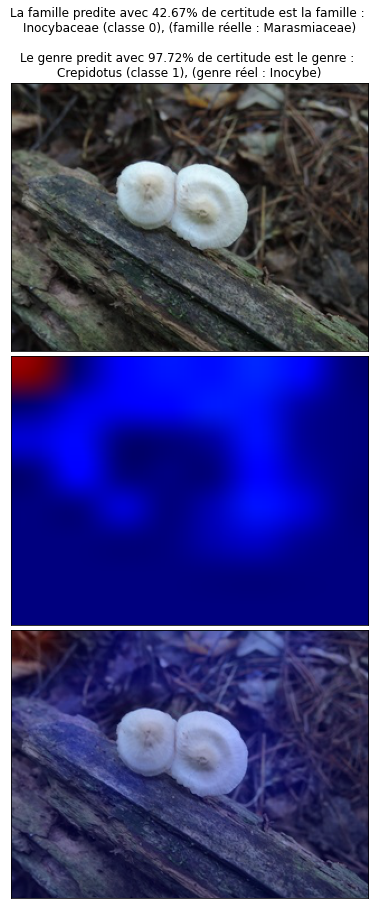

In [30]:
###
##
# Set the image you want to analyze !
# 
#image_numb = 268
## Or take a random image : (comment one solution...)
image_numb = random.randrange(1,len(data_test))
#
#
##
###

##

img_size = (256, 256)
last_conv_layer_name = "top_conv"
inner_model_fam = model_fam.get_layer("efficientnetb1")
preprocess_input = keras.applications.efficientnet.preprocess_input

# Prepare image
img_path = data_test['filepath'].iloc[image_numb]
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
model_fam.layers[-1].activation = None

# Print what the top predicted class is
preds = model_fam.predict(img_array)
predict = tf.argmax(preds, axis = 1).numpy()
final_prob = round(max(preds[0])*100, 2)

vector_probability , final_probability = softmax(preds[0])
class_predict = np.argmax(vector_probability)

true_label = data_test["label_family"].iloc[image_numb]
true_fam = family_names[true_label]

#print("La famille predite avec {}% de certitude est la famille : \n{} (classe {}), (famille réelle : {})" .format(final_probability, family_names[class_predict], class_predict, true_fam))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_fam, inner_model_fam, last_conv_layer_name, pred_index=predict[0])


## Indicate the predicted family number

fam_number = predict[0]

if fam_number == 0:
    model_genus = model_label0
    genus_name = genus_names_label0
elif fam_number == 1:
    model_genus = model_label1
    genus_name = genus_names_label1
elif fam_number == 2:
    model_genus = model_label2
    genus_name = genus_names_label2
elif fam_number == 3:
    model_genus = model_label3
    genus_name = genus_names_label3
elif fam_number == 4:
    model_genus = model_label4
    genus_name = genus_names_label4

inner_model_genus = model_genus.get_layer("efficientnetb1")
    
# Remove last layer's softmax
model_genus.layers[-1].activation = None

preds_genus = model_genus.predict(img_array)
predict_genus = tf.argmax(preds_genus, axis = 1).numpy()
final_prob_genus = round(max(preds_genus[0])*100, 2)

vector_probability_genus , final_probability_genus = softmax(preds_genus[0])
class_predict_genus = np.argmax(vector_probability_genus)

imid = data_test["image_id"].iloc[image_numb]
#true_genus_label = data_test[data_test["image_id"]==imid]["label"].values[0]
true_genus_label = data_test["label"].iloc[image_numb]
true_genus_name = genus_name[true_genus_label]


## solution famille si softmax
#title1 = "La famille predite avec {}% de certitude est la famille : \n{} (classe {}), (famille réelle : {})" .format(final_prob, family_names[predict[0]], predict[0], true_fam)
#print("La famille predite avec {}% de certitude est la famille : \n{} (classe {}), (famille réelle : {})" .format(final_prob, family_names[predict[0]], predict[0], true_fam))

## solution famille si PAS softmax
title1 = "La famille predite avec {}% de certitude est la famille : \n{} (classe {}), (famille réelle : {})" .format(final_probability, family_names[class_predict], class_predict, true_fam)
#print("La famille predite avec {}% de certitude est la famille : \n{} (classe {}), (famille réelle : {})" .format(final_probability, family_names[class_predict], class_predict, true_fam))

## solution genus si softmax
#title2 = "Le genre predit avec {}% de certitude est le genre : \n{} (classe {}), (genre réel : {})" .format(final_prob_genus, genus_name[predict_genus[0]], predict_genus[0], true_genus_name)
#print("Le genre predit avec {}% de certitude est le genre : \n{} (classe {}), (genre réel : {})" .format(final_prob_genus, genus_name[predict_genus[0]], predict_genus[0], true_genus_name))

## solution genus si PAS softmax
title2 = "Le genre predit avec {}% de certitude est le genre : \n{} (classe {}), (genre réel : {})" .format(final_probability_genus, genus_name[class_predict_genus], class_predict_genus, true_genus_name)
#print("Le genre predit avec {}% de certitude est le genre : \n{} (classe {}), (genre réel : {})" .format(final_probability_genus, genus_name[class_predict_genus], class_predict_genus, true_genus_name))

img, jet_heatmap2, superimposed_img = save_and_display_gradcam(img_path, heatmap)
plt.figure(figsize=(10,15))
plt.subplots_adjust(wspace=0, hspace=0.02)
plt.subplot(311)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title(title1 + "\n\n" + title2)
plt.subplot(312)
plt.imshow(jet_heatmap2)
plt.xticks([])
plt.yticks([])
plt.subplot(313)
plt.imshow(superimposed_img);
plt.xticks([])
plt.yticks([]);